### Imports

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import time

from cca_algorithms import bio_cca, gen_oja, bio_rrr, asy_cca, adaptive_bio_cca
from util import correlation_matrix, add_fill_lines

### Load dataset

In [2]:
dataset = 'adaptive'

In [3]:
# load dataset

if dataset=='synthetic':
    X = np.load('datasets/synthetic/view1.npy')
    Y = np.load('datasets/synthetic/view2.npy')
elif dataset=='mediamill':
    X = np.load('datasets/mediamill/view1.npy')
    Y = np.load('datasets/mediamill/view2.npy')
elif dataset=='adaptive':
    modes = ["A", "B", "C"]
    X, Y = {}, {}
    X["A"] = np.load('datasets/adaptive/view1a.npy')
    Y["A"] = np.load('datasets/adaptive/view2a.npy')
    X["B"] = np.load('datasets/adaptive/view1b.npy')
    Y["B"] = np.load('datasets/adaptive/view2b.npy')
    X["C"] = np.load('datasets/adaptive/view1c.npy')
    Y["C"] = np.load('datasets/adaptive/view2c.npy')

# dataset dimensions

x_dim = X["A"].shape[0]
y_dim = Y["A"].shape[0]

samples = {"A": X["A"].shape[1], "B": X["B"].shape[1], "C": X["C"].shape[1]}

### Offline solution

In [4]:
Cxx, Cyy, Cxy, Rxy, u, canonical_correlations, vh = {}, {}, {}, {}, {}, {}, {}

for mode in modes:
    Cxx[mode] = X[mode]@X[mode].T/samples[mode]
    Cyy[mode] = Y[mode]@Y[mode].T/samples[mode]
    Cxy[mode] = X[mode]@Y[mode].T/samples[mode]
    Rxy[mode] = correlation_matrix(Cxx[mode],Cyy[mode],Cxy[mode])
    u[mode], canonical_correlations[mode], vh[mode] = np.linalg.svd(Rxy[mode])

### Plot canonical correlations

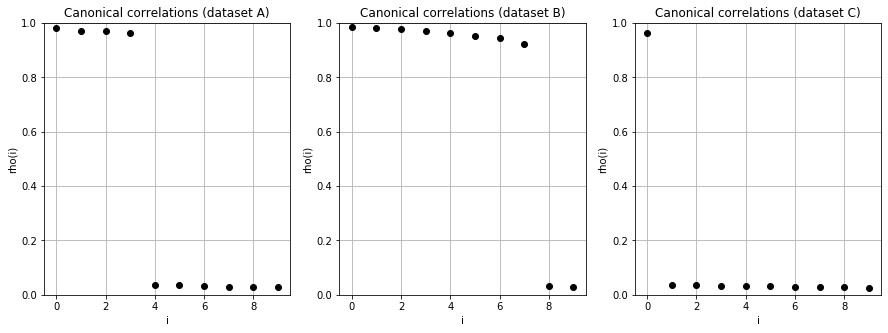

In [16]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1, 3, 1)

ax.plot(canonical_correlations["A"], 'o', color='black')
plt.xlim(-.5,9.5)
plt.ylim(0,1)
plt.title('Canonical correlations (dataset A)')
plt.xlabel('i')
plt.ylabel('rho(i)')
plt.grid()

ax = plt.subplot(1, 3, 2)

ax.plot(canonical_correlations["B"], 'o', color='black')
plt.xlim(-.5,9.5)
plt.ylim(0,1)
plt.title('Canonical correlations (dataset B)')
plt.xlabel('i')
plt.ylabel('rho(i)')
plt.grid()

ax = plt.subplot(1, 3, 3)

ax.plot(canonical_correlations["C"], 'o', color='black')
plt.xlim(-.5,9.5)
plt.ylim(0,1)
plt.title('Canonical correlations (dataset C)')
plt.xlabel('i')
plt.ylabel('rho(i)')
plt.grid()

plt.show()

In [9]:
r = {"A": 4, "B": 8, "C":1}

### Online algorithms

In [6]:
# Parameters

trials = 1; z_dim = 10; iters = 0

for mode in modes:
    iters += samples[mode]

In [7]:
# Maximum of the objective

max_obj = {}

for mode in modes:
    max_obj[mode] = sum(canonical_correlations[mode][:z_dim]/2)

In [18]:
# Optimal subspace projections

Ux, Uy, Px_opt, Py_opt = {}, {}, {}, {}

for mode in modes:
    Ux[mode] = u[mode][:,:r[mode]]
    Uy[mode] = vh[mode].T[:,:r[mode]]

    Px_opt[mode] = Ux[mode]@np.linalg.inv(Ux[mode].T@Ux[mode])@Ux[mode].T
    Py_opt[mode] = Uy[mode]@np.linalg.inv(Uy[mode].T@Uy[mode])@Uy[mode].T

In [8]:
# Specify which algorithms to run

algorithms = []

algorithms.append('Adaptive Bio-CCA')
# algorithms.append('Bio-CCA')
# if z_dim==1: algorithms.append('Gen-Oja')
# algorithms.append('Asymmetric-CCA')
algorithms.append('Bio-RRR')

In [20]:
alg_error = {}
alg_subspacex_error = {}
alg_time = {}

for alg in algorithms:
    alg_time[alg] = np.zeros((trials,iters))
    alg_subspacex_error[alg] = np.zeros((trials,iters))

In [21]:
start_time = time.time()

for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
                
    # Initialize Bio-CCA
    
    if 'Adaptive Bio-CCA' in algorithms:
        adaptive = adaptive_bio_cca(z_dim,x_dim,y_dim,dataset)
        adaptive_Vx = np.zeros((iters,x_dim,z_dim))
        adaptive_Vy = np.zeros((iters,y_dim,z_dim))
    
    if 'Bio-CCA' in algorithms:
        biocca = bio_cca(z_dim,x_dim,y_dim,dataset)   
        biocca_Vx = np.zeros((iters,x_dim,z_dim))
        biocca_Vy = np.zeros((iters,y_dim,z_dim))
    
    # Initialize Asymmetric-CCA
        
    if 'Asymmetric-CCA' in algorithms:
        if dataset=='synthetic': asycca = CCAPyramidal(X,Y,k=z_dim,eta={"W":0.002,"V":0.002,"M":0.002,"Lambda":0.002,"Gamma":0.002},steps=iters,alpha=5e-6,mode="hierarchy")
        elif dataset=='mediamill': asycca = CCAPyramidal(X,Y,k=z_dim,eta={"W":0.002,"V":0.002,"M":0.002,"Lambda":0.002,"Gamma":0.002},steps=iters,alpha=5e-6,mode="hierarchy")
            
        asycca_Vx = np.zeros((iters,x_dim,z_dim))
        asycca_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Bio-RRR
        
    if 'Bio-RRR' in algorithms:
        biorrr = bio_rrr(z_dim,x_dim,y_dim,dataset)
        biorrr_Vx = np.zeros((iters,x_dim,z_dim))
        biorrr_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Gen-Oja
    
    if 'Gen-Oja' in algorithms:
        genoja = gen_oja(x_dim,y_dim,dataset)
        genoja_vx = np.zeros((iters,x_dim,1))
        genoja_vy = np.zeros((iters,y_dim,1))
            
    # Run online algorithms
    
    print('Running online algorithms...')
    
    i_epoch = 0
    
    for mode in modes:
        
        print(f'Mode {mode}:')
        
        # Random permutation of the inputs

        idx = np.random.permutation(samples[mode])
    
        # Online updates

        for i_sample in range(samples[mode]):
            
            i_iter = i_epoch*samples + i_sample

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            # online updates

            if 'Adaptive Bio-CCA' in algorithms:
                checkpoint = time.time()
                adaptive_Vx[i_iter], adaptive_Vy[i_iter] = adaptive.fit_next(x,y)
                alg_time['Adaptive Bio-CCA'][i_trial,i_iter] = alg_time['Adaptive Bio-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Bio-CCA' in algorithms:
                checkpoint = time.time()
                biocca_Vx[i_iter], biocca_Vy[i_iter] = biocca.fit_next(x,y)
                alg_time['Bio-CCA'][i_trial,i_iter] = alg_time['Bio-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'MSG-CCA' in algorithms: 
                checkpoint = time.time()
                msgcca_M[i_iter] = msgcca.fit_next(x,y)
                alg_time['MSG-CCA'][i_trial,i_iter] = alg_time['MSG-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Asymmetric-CCA' in algorithms: 
                checkpoint = time.time()
                asycca.online_step(idx[i_sample], asycca.decay(i_iter))
                asycca_Vx[i_iter], asycca_Vy[i_iter] = asycca.W, asycca.V
                alg_time['Asymmetric-CCA'][i_trial,i_iter] = alg_time['Asymmetric-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Bio-RRR' in algorithms: 
                checkpoint = time.time()
                biorrr_Vx[i_iter], biorrr_Vy[i_iter] = biorrr.fit_next(x,y)
                alg_time['Bio-RRR'][i_trial,i_iter] = alg_time['Bio-RRR'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Gen-Oja' in algorithms: 
                checkpoint = time.time()
                genoja_vx[i_iter], genoja_vy[i_iter] = genoja.fit_next(x,y)
                alg_time['Gen-Oja'][i_trial,i_iter] = alg_time['Gen-Oja'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
                
        print(f'Elapsed time: {time.time()-start_time} seconds')
        
        i_epoch+=1
        
    # Compute error
                
    print('Computing errors...')

    for i_iter in range(iters):
        if 'Adaptive Bio-CCA' in algorithms:
            alg_subspacex_error['Adaptive Bio-CCA'][i_trial,i_iter] = subspace_error(adaptive_Vx[i_iter], Px_opt)
        if 'Bio-CCA' in algorithms: 
            alg_subspacex_error['Bio-CCA'][i_trial,i_iter] = subspace_error(biocca_Vx[i_iter], Px_opt)
        if 'Asymmetric-CCA' in algorithms: 
            alg_subspacex_error['Asymmetric-CCA'][i_trial,i_iter] = subspace_error(asycca_Vx[i_iter], Px_opt)
        if 'Bio-RRR' in algorithms:
            alg_subspacex_error['Bio-RRR'][i_trial,i_iter] = subspace_error(biorrr_Vx[i_iter], Px_opt)
        if 'Gen-Oja' in algorithms: 
            alg_subspacex_error['Gen-Oja'][i_trial,i_iter] = subspace_error(genoja_vx[i_iter], Px_opt)
            
    print(f'Elapsed time: {time.time()-start_time} seconds')

# save data 
            
pkl.dump(alg_subspacex_error, open(f'error/{dataset}_{z_dim}-dim_subspacex_error.p', 'wb'))
pkl.dump(alg_time, open(f'error/{dataset}_{z_dim}-dim_time.p', 'wb'))

print('Trials complete')

Trial 1 out of 1:
The optimal learning rates for this dataset are not stored
The optimal learning rates for this dataset are not stored
Running online algorithms...
Mode A:


TypeError: 'dict' object cannot be interpreted as an integer